# Lab assignment: unemployment rates

In this assignment we will estimate unemployment rates in Spain, using *pandas* for reading information, *scikit-learn* for training estimators, and *geopandas* and *folium* for visualizing results.

## 0. Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table align="center">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve a question. You should pay attention to these hints to better understand questions.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>

During the assignment you will make use of several Python packages that might not be installed in your machine. It is strongly recommended that you use the environment file *environment.yml* and follow the instructions of the following <a href="https://github.com/jorloplaz/teaching_material/tree/master/SVM">link</a>.

If you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells.

Make sure the following cell executes correctly, as it imports all you will need:

In [1]:
import pandas as pd
import numpy as np
import branca.colormap as cm
import seaborn as sns
#import holoviews as hv; hv.extension('bokeh')
import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.exceptions import ConvergenceWarning
from math import ceil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
from IPython.display import IFrame
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error as MAE
import statistics as stats
import glob

## 1. Load and understand data

To begin with, let us read some **numerical characteristics of Spanish municipalities**: 

In [2]:
muns_population = utils.read_population('./data/municipios.csv')
print(f'Characteristics of {len(muns_population)} municipalities')
muns_population.tail()

Characteristics of 8112 municipalities


lat       lon        alt  \
com_aut  prov              mun                                        
Valencia Valencia/València Xeresa     39.00910 -0.217992   34.05847   
                           Xirivella  39.46669 -0.427794   35.01973   
                           Yátova     39.38500 -0.808174  441.81140   
                           Yesa, La   39.49916 -0.426125   52.28455   
                           Zarra      39.09138 -1.075068  576.03660   

                                      habitantes  
com_aut  prov              mun                    
Valencia Valencia/València Xeresa           2221  
                           Xirivella       30691  
                           Yátova           2199  
                           Yesa, La          260  
                           Zarra             551

As you can see, **for each municipality we have its position (latitude and longitude in degrees), its altitude (in meters) and its population (number of inhabitants)**. The resulting dataframe is **indexed in a hierarchical way, first by autonomous community (*COM_FIELD*), then by province (*PROV_FIELD*), and finally by municipality name (*MUN_FIELD*), for a total of 8112 municipalities**.

Our goal is to **predict the yearly unemployment rate for each municipality in 2018**. Let us read the unemployment data belonging to that year:

In [3]:
unempl_2018 = utils.read_unemployment('./data/Paro_por_municipios_2018.csv')   # use specific load function from utils module
num_muns = len(unempl_2018.index.unique())    # distinct municipalities
print(f'unempl_2018 = {len(unempl_2018)} unemployment data from {num_muns} municipalities')
unempl_2018.head()

unempl_2018 = 97516 unemployment data from 8127 municipalities


año  mes  parados
com_aut   prov    mun                          
Andalucía Almería Abla       2018    1       77
                  Abrucena   2018    1       69
                  Adra       2018    1     2001
                  Albánchez  2018    1       31
                  Alboloduy  2018    1       33

These data are indexed in the same way as *muns_population* above. However, we are interested in yearly unemployment, but **we have monthly information** (actually, 97516 observations from 8127 municipalities). For example, taking the municipality of Abla:

In [4]:
unempl_2018.xs(key='Abla', level=utils.MUN_FIELD, drop_level=False)      # all records whose mun is Abla

año  mes  parados
com_aut   prov    mun                     
Andalucía Almería Abla  2018    1       77
                  Abla  2018    2       75
                  Abla  2018    3       69
                  Abla  2018    4       71
                  Abla  2018    5       75
                  Abla  2018    6       70
                  Abla  2018    7       63
                  Abla  2018    8       73
                  Abla  2018    9       70
                  Abla  2018   10       65
                  Abla  2018   11       73
                  Abla  2018   12       74

Using grouping, it is fairly easy to obtain the **yearly means** for each municipality:

In [5]:
unempl_2018_means = (unempl_2018
                         .groupby(unempl_2018.index.names)   # by the whole hierarchy
                         [[utils.UNEMPL_FIELD]]    # just unemployment column
                         .mean())   # take mean
assert(len(unempl_2018_means) == num_muns)       # there should be just 1 row for each municipality
unempl_2018_means.head()

parados
com_aut   prov    mun                   
Andalucía Almería Abla         71.250000
                  Abrucena     69.166667
                  Adra       2419.583333
                  Alboloduy    30.750000
                  Albox       794.583333

Now, in order to obtain our target values, we just need to transform these raw figures to unemployment rates, that is, we have to **divide unemployment by each municipality's population**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create a <i>Y</i> vector (i.e., a Pandas <i>Series</i>) with the mean unemployment rates.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    You should join the frames <i>unempl_2018_means</i> and <i>muns_population</i>. Then divide the mean unemployed people by the inhabitants.
    <br>
    Be careful while joining! There are some municipalities present in <i>unempl_2018_means</i> but missing in <i>muns_population</i> (8127 vs. 8112), which can lead to <i>nan</i> values when dividing.
</td></tr>
</table>

In [6]:
join=unempl_2018_means.merge(muns_population,on=["com_aut","prov","mun"])
Y= join.parados/join.habitantes
Y

com_aut    prov               mun      
Andalucía  Almería            Abla         0.047374
                              Abrucena     0.051578
                              Adra         0.099273
                              Alboloduy    0.045623
                              Albox        0.071085
                                             ...   
Valencia   Valencia/València  Xàtiva       0.081808
                              Yesa, La     0.023077
                              Yátova       0.059573
                              Zarra        0.029643
                              Ènova, l'    0.047397
Length: 8111, dtype: float64

Make sure you did things correctly:

In [7]:
assert(len(Y) <= min(len(unempl_2018_means), len(muns_population)))  # join can't be larger than any of the joined frames
assert(isinstance(Y, pd.Series))     # a series

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Can you list the following?
<ul>
    <li>Municipalities with known unemployment but unknown population.</li>
    <li>Municipalities with known population but unknown unemployment.</li>
    <li>The reason why len(unempl_2018) != num_muns*12.</li>
 </td></tr>
</table>

<font color='brown'>Estos son los municipios de los que conocemos su tasa de paro, pero no el número de habitantes:</font>

In [8]:
desempleados_poblacion= unempl_2018_means.merge(muns_population,how="left", on=["com_aut","prov","mun"])
desempleados_poblacion_nulos=desempleados_poblacion[pd.isnull(desempleados_poblacion).any(axis=1)]
print("El número de municipios donde conocemos su tasa de paro, "
      "pero no su número de habitantes es:",desempleados_poblacion_nulos.shape[0])
desempleados_poblacion_nulos

El número de municipios donde conocemos su tasa de paro, pero no su número de habitantes es: 16


parados  \
com_aut     prov      mun                                                     
Andalucía   Almería   Balanegra                                  198.166667   
            Granada   Dehesas Viejas                              53.583333   
                      Domingo Pérez de Granada                    54.750000   
                      Játar                                       22.416667   
                      Valderrubio                                133.833333   
            Málaga    Montecorto                                  53.333333   
                      Serrato                                     44.166667   
                      Villanueva de la Concepción                213.166667   
Catalunya   Tarragona Canonja, La                                306.666667   
Extremadura Badajoz   Guadiana del Caudillo                      216.500000   
            Cáceres   Alagón del Río                              79.833333   
                      Pueblonuevo de Miramontes                   24.750000   
                      Tiétar                                      49.833333   
                      Vegaviana                                   93.000000   
Galicia     A Coruña  Oza-Cesuras                                  0.000000   
Navarra     Navarra   Noáin (Valle de Elorz)/Noain (Elortzibar)  445.916667   

                                                                 lat  lon  \
com_aut     prov      mun                                                   
Andalucía   Almería   Balanegra                                  NaN  NaN   
            Granada   Dehesas Viejas                             NaN  NaN   
                      Domingo Pérez de Granada                   NaN  NaN   
                      Játar                                      NaN  NaN   
                      Valderrubio                                NaN  NaN   
            Málaga    Montecorto                                 NaN  NaN   
                      Serrato                                    NaN  NaN   
                      Villanueva de la Concepción                NaN  NaN   
Catalunya   Tarragona Canonja, La                                NaN  NaN   
Extremadura Badajoz   Guadiana del Caudillo                      NaN  NaN   
            Cáceres   Alagón del Río                             NaN  NaN   
                      Pueblonuevo de Miramontes                  NaN  NaN   
                      Tiétar                                     NaN  NaN   
                      Vegaviana                                  NaN  NaN   
Galicia     A Coruña  Oza-Cesuras                                NaN  NaN   
Navarra     Navarra   Noáin (Valle de Elorz)/Noain (Elortzibar)  NaN  NaN   

                                                                 alt  \
com_aut     prov      mun                                              
Andalucía   Almería   Balanegra                                  NaN   
            Granada   Dehesas Viejas                             NaN   
                      Domingo Pérez de Granada                   NaN   
                      Játar                                      NaN   
                      Valderrubio                                NaN   
            Málaga    Montecorto                                 NaN   
                      Serrato                                    NaN   
                      Villanueva de la Concepción                NaN   
Catalunya   Tarragona Canonja, La                                NaN   
Extremadura Badajoz   Guadiana del Caudillo                      NaN   
            Cáceres   Alagón del Río                             NaN   
                      Pueblonuevo de Miramontes                  NaN   
                      Tiétar                                     NaN   
                      Vegaviana                                  NaN   
Galicia     A Coruña  Oza-Cesuras                                NaN   
Navarra     Navarra   Noáin (Valle

<font color='brown'>Municipios donde conocemos la población pero no el desempleo:</font>

In [9]:
poblacion_desempleados= unempl_2018_means.merge(muns_population,how="right", on=["com_aut","prov","mun"])
poblacion_desempleados_nulos=poblacion_desempleados[pd.isnull(poblacion_desempleados).any(axis=1)]
print("El número de municipios donde conocemos su número de habitantes, "
      "pero no su tasa de paro es:",poblacion_desempleados_nulos.shape[0])
poblacion_desempleados_nulos

El número de municipios donde conocemos su número de habitantes, pero no su tasa de paro es: 1


,,,parados,lat,lon,alt,habitantes
com_aut,prov,mun,,,,,
Navarra,Navarra,Noáin/Noain,NaN,42.7599,-1.633801,459.8526,6806


<font color='brown'>A continuación, vamos a comprobar por qué len(unempl_2018) != num_muns*12.</font>

In [10]:
print("El número de municipios por 12 meses de cada municipio:",num_muns*12)
print("El número de registros del dataset unempl_2018 es:",len(unempl_2018))
print("Nos encontramos con una diferencia de:",(num_muns*12)-len(unempl_2018),"registros")

El número de municipios por 12 meses de cada municipio: 97524
El número de registros del dataset unempl_2018 es: 97516
Nos encontramos con una diferencia de: 8 registros


<font color='brown'>Vamos a comprobar que todos los municipios tengan 12 registros, es decir, uno por cada mes:</font>

In [11]:
indices_unempl_2018=unempl_2018.index.unique()
municipios_con_meses_nan=[i for i in indices_unempl_2018 if unempl_2018.xs(key=(i)).count()["mes"]<12]
municipios_con_meses_nan

C:\Users\Luis\Anaconda3\envs\datahack_algs_avanzados_svm\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


[('Extremadura', 'Cáceres', 'Pueblonuevo de Miramontes')]

In [12]:
unempl_2018.xs(key=municipios_con_meses_nan[0]).count()["mes"]

C:\Users\Luis\Anaconda3\envs\datahack_algs_avanzados_svm\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


4

<font color='brown'>Observamos que para el municipio Pueblo de Miramontes de Cáceres, Extremadura, sólo tenemos 4 registros, y deberíamos tener 12 registros, uno por cada mes. Aquí tenemos los 8 registros que faltan en el dataframe "unempl_2018".</font>

## 2. Build and test a dummy baseline model

In order to build models, we need to **split the data into training and set sets**. Let us fix the random seed and the ratio of data for training and test:

In [13]:
RANDOM_STATE = 42   # fix seed
TEST_PERC = 0.3     # 30% for test, 70% for training

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Split <i>Y</i> into training and test sets, so that you obtain variables <i>Y_train</i> and <i>Y_test</i>. Use both constants <i>RANDOM_STATE</i> and <i>TEST_PERC</i>.
 </td></tr>
</table>

In [14]:
Y_train,Y_test=train_test_split(Y,test_size=TEST_PERC,random_state=RANDOM_STATE)
print("Nuestro Y_train es:")
print(Y_train)
print("\n")
print("Nuestro Y_test es:")
print(Y_test)

Nuestro Y_train es:
com_aut             prov              mun                 
Castilla La Mancha  Guadalajara       Rueda de la Sierra      0.006173
Castilla León       Salamanca         Galindo y Perahuy       0.048592
Aragón              Teruel            Gea de Albarracín       0.029412
Castilla León       Salamanca         Santiz                  0.044300
Andalucía           Cádiz             Villamartín             0.130529
                                                                ...   
Catalunya           Barcelona         Vallcebre               0.021149
                    Girona            Rupià                   0.029835
Aragón              Huesca            Foradada del Toscar     0.009218
Valencia            Alicante/Alacant  Benilloba               0.071514
Navarra             Navarra           Salinas de Oro/Jaitz    0.042754
Length: 5677, dtype: float64


Nuestro Y_test es:
com_aut             prov               mun                    
Castilla La Mancha  Cuenca 

Let us verify that data have been split correctly:

In [15]:
assert(len(Y_test) == ceil(TEST_PERC*len(Y)) and type(Y_test) == type(Y))  # test set size is 30% of total size
assert(len(Y_train) == len(Y) - len(Y_test) and type(Y_train) == type(Y))  # when not in test, should be in train
assert(Y_train.index.intersection(Y_test.index).empty)   # there's no municipality present both in train and test

Our goal thus is to predict as good as possible the values of *Y_test*. Because these data are relative to physical places, we can plot them in a map as follows. First, we create a color range to cover the different rates we have:

In [16]:
color_range = cm.LinearColormap(colors=['green', 'yellow', 'orange', 'red', 'black'], 
                                vmin=round(Y.min(), 2), vmax=round(Y.max(), 2), caption='Unemployment rate')
color_range

And read the communities and provinces polygons:

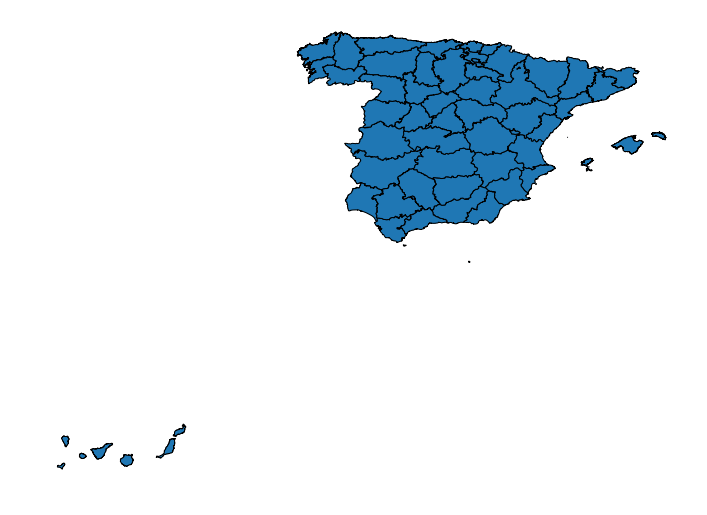

In [17]:
coms = utils.read_communities('./data/ComunidadesAutonomas_ETRS89_30N/')      # read communities
provs = utils.read_provinces('./data/Provincias_ETRS89_30N/')     # read provinces
_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax = coms.plot(ax=ax)
ax.axis('off')
provs.plot(ax=ax, edgecolor='black');

The following code uses these polygons and the color range to generate the map corresponding to the true values of Y_test, saving this map as an HTML document:

In [18]:
filename = './true_vals.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[Y_test.index], Y_test], axis=1),  # map needs X and Y together...
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,   # columns with latitude and longitude
                       unemploy_col=Y_test.name if Y_test.name is not None else 0,   # column with unemployment ('0' if unnamed)
                       cmap=color_range, coms=coms, provs=provs, 
                       filename=filename)    # colors, communities, provinces and where to store the map

You can open the generated HTML in another tab, but embedding it directly in the notebook is as simple as:

In [19]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>Se observa la tendencia de mayor tasa de paro hacia el sur y una ligera tendencia de mayor tasa de paro hacia el este y el oeste de la meseta.</font>

In [20]:
filename = './true_vals_train.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[Y_train.index], Y_train], axis=1),  # map needs X and Y together...
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,   # columns with latitude and longitude
                       unemploy_col=Y_train.name if Y_train.name is not None else 0,   # column with unemployment ('0' if unnamed)
                       cmap=color_range, coms=coms, provs=provs, 
                       filename=filename)    # colors, communities, provinces and where to store the map

In [21]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>En el conjunto de train se observan las mismas tendencias que en el conjunto de test, aunque como es lógico, con más registros.</font>

Ideally, **we should obtain a similar map when predicting with a model**. We already have Y, but we need patterns X to train such a model. Which features should we use? Before thinking about it, let us build a dummy model that does not even need features. An obvious option that comes to mind is to **predict always the mean unemployment rate**, irrespective of the municipality:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Build this dummy model that always predicts the mean, call it <i>dummy</i>, fit it on train and measure its score on both the train and test sets. What do you observe? Why is that?
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Use a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html">DummyRegressor</a>, and recall that the default metric for regressors in scikit-learn is the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination">R² score</a>.
 </td></tr>
</table>

In [22]:
dummy= DummyRegressor(strategy='mean')

<font color='brown'>Nuestro modelo dummy no va a usar features para calcular su predicción, ya que realizará la media del target. Aún así, es necesario que se le aporten las features, por lo que crearemos una matriz de ceros con el mismo número de registros de train que llamaremos X_train_zeros, y otra con el mismo número de registros de test que llamaremos X_test_zeros:</font>

In [23]:
X_train_zeros=[[0]]*len(Y_train)
dummy.fit(X_train_zeros,Y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [24]:
print("El score (R^2) de nuestro modelo dummy en train es:",dummy.score(X_train_zeros, Y_train))

El score (R^2) de nuestro modelo dummy en train es: 0.0


In [25]:
X_test_zeros=[[0]]*len(Y_test)
print("El score (R^2) de nuestro modelo dummy en test es:",dummy.score(X_test_zeros, Y_test))

El score (R^2) de nuestro modelo dummy en test es: -0.0009118628050082123


<font color='brown'>Observamos que nuestro modelo ofrece un **R^2 en train de 0.0** y un **R^2 en test de -0.0009118628050082123**. Esto es debido a que el coeficiente de determinación (R^2) es la suma de errores al cuadrado partido la suma de la variación de la media al cuadrado.
Esto significa que nuestro modelo en train comete un error máximo, no captura la varianza de los datos en el ajuste lineal, ya que sólo predice la media. Un modelo constante que siempre predice el valor esperado de y, sin tener en cuenta las características de entrada, obtiene una puntuación R^2 de 0.0, llegando incluso a ser negativo, como en nuestro caso de test porque el modelo puede ser arbitrariamente peor.  
  
Vamos a comprobar visualmente como predice el modelo dummy calculando el error absoluto entre las Y predichas y las Y reales. También calcularemos el MAE (error absoluto medio) de nuestro modelo:</font>

In [26]:
dummy_preds=dummy.predict(X_test_zeros)
dummy_preds

array([0.04729104, 0.04729104, 0.04729104, ..., 0.04729104, 0.04729104,
       0.04729104])

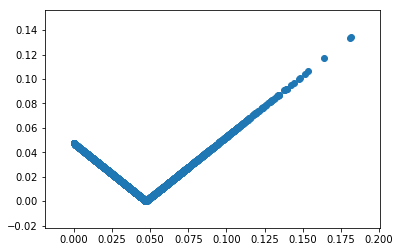

In [27]:
error_dummy=abs(Y_test-dummy_preds)
plt.scatter(x=Y_test,y=error_dummy);

In [28]:
MAE_dummy=MAE(y_true=Y_test,y_pred=dummy_preds)
print("El MAE del modelo dummy es:",MAE_dummy)

El MAE del modelo dummy es: 0.02295565938940183


<font color='brown'>En el gráfico podemos ver el error de las predicciones del modelo dummy con respecto al valor real (Y_test). Como es lógico, cuanto más se aleja el valor real de la media (error cero), mayor es el error.  
El **MAE del modelo dummy es 0.02295565938940183**, es decir, la media del valor absoluto de la diferencias entre los valores reales del target y los valores predichos por nuestro modelo.
    
Vamos a comprobar si existe algún municipio cuyo valor sea la media o un valor cercano:</font>

In [29]:
aciertos_dummy=error_dummy==0
print("El modelo dummy ha acertado la tasa de paro en:",error_dummy[aciertos_dummy].shape[0],"municipios")

El modelo dummy ha acertado la tasa de paro en: 0 municipios


In [30]:
casi_aciertos_dummy=error_dummy<0.001
print("El modelo dummy ha acertado la tasa de paro con un margen de error de 0.001 en:",
      error_dummy[casi_aciertos_dummy].shape[0],"municipios")

El modelo dummy ha acertado la tasa de paro con un margen de error de 0.001 en: 79 municipios


<font color='brown'>No exite ningún municipio cuyo valor sea la media. Sin embargo, existen 79 municipios con valores muy cercanos a la media.</font>

We verify that this dummy always predicts the mean (taken on the train set) for whichever test pattern (here represented as *None*):

In [31]:
assert(dummy.predict([None]) == Y_train.mean())   # always predicts mean

Think of what the resulting map will look like, and confirm it:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create the map with the predictions of the dummy model (store them in <i>dummy_preds.html</i>). What color is it? Why is it that color?
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    You have to call <i>predict</i> for the whole test set, which gives you a numpy array. Transform this array into a <i>Series</i> that can be concatenated with <i>muns_population</i> so that you can call <i>generate_map</i>. Do not read communities nor provinces again, cause they have been already loaded in memory.
 </td></tr>
</table>

In [32]:
dummy_preds=pd.Series(data=dummy_preds, index=Y_test.index)
dummy_preds

com_aut             prov               mun                    
Castilla La Mancha  Cuenca             Valle de Altomira, El      0.047291
Andalucía           Huelva             San Silvestre de Guzmán    0.047291
Valencia            Valencia/València  Puçol                      0.047291
Catalunya           Barcelona          Orpí                       0.047291
                    Girona             Pau                        0.047291
                                                                    ...   
Navarra             Navarra            Irurtzun                   0.047291
Andalucía           Huelva             Villalba del Alcor         0.047291
Castilla La Mancha  Ciudad Real        Villarta de San Juan       0.047291
Castilla León       Salamanca          Valdelageve                0.047291
Aragón              Huesca             Arén                       0.047291
Length: 2434, dtype: float64

In [33]:
filename = './dummy_preds.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[dummy_preds.index], dummy_preds], axis=1),
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,
                       unemploy_col=dummy_preds.name if dummy_preds.name is not None else 0,
                       cmap=color_range, coms=coms, provs=provs,
                       filename=filename)

<font color='brown'>Vamos a mantener los valores de la leyenda iguales para todos los modelos para poder ver más fácilmente las diferencias entre los distintos modelos.</font>

In [34]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>Todos puntos tienen el mismo color verde, debido a que este modelo simplemente predice el valor medio del ratio de empleo (Y_train) de España, que es 0.047291.</font>

## 3. Build and test SVM models

### 3.1 Using general features

Time to create some actual features X for non-dummy models. Our first choice is to use the numerical features in *muns_population*. That is, **we will use the longitude, latitude, altitude and number of inhabitants as features**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create an <i>X</i> matrix (as a Pandas <i>DataFrame</i>) with the features for each municipality present in <i>muns_population</i>, and split it in <i>X_train</i> and <i>X_test</i>, as you did for <i>Y</i>.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    Try not to call <i>train_test_split</i> again! <i>Y_train</i> and <i>Y_test</i> already have the split municipalities, so it is completely unnecessary to split them in the same way.
</td></tr>
</table>

In [35]:
X=join.drop(labels=(["parados"]),axis=1)
X

lat       lon        alt  \
com_aut   prov              mun                                        
Andalucía Almería           Abla       37.14114 -2.780104  871.16840   
                            Abrucena   37.13305 -2.797098  976.93870   
                            Adra       36.74807 -3.022522   10.97898   
                            Alboloduy  37.03319 -2.621750  388.43460   
                            Albox      37.38979 -2.147483  426.42680   
...                                         ...       ...        ...   
Valencia  Valencia/València Xàtiva     38.98887 -0.515614  118.28640   
                            Yesa, La   39.49916 -0.426125   52.28455   
                            Yátova     39.38500 -0.808174  441.81140   
                            Zarra      39.09138 -1.075068  576.03660   
                            Ènova, l'  39.04391 -0.480266   57.11230   

                                       habitantes  
com_aut   prov              mun                    
Andalucía Almería           Abla             1504  
                            Abrucena         1341  
                            Adra            24373  
                            Alboloduy         674  
                            Albox           11178  
...                                           ...  
Valencia  Valencia/València Xàtiva          29386  
                            Yesa, La          260  
                            Yátova           2199  
                            Zarra             551  
                            Ènova, l'        1018  

[8111 rows x 4 columns]

In [36]:
X_train=X.loc[Y_train.index]
X_train

lat       lon  \
com_aut            prov             mun                                        
Castilla La Mancha Guadalajara      Rueda de la Sierra    40.91821 -1.854492   
Castilla León      Salamanca        Galindo y Perahuy     40.94322 -5.871698   
Aragón             Teruel           Gea de Albarracín     40.41083 -1.348030   
Castilla León      Salamanca        Santiz                41.20575 -5.895741   
Andalucía          Cádiz            Villamartín           36.86132 -5.641834   
...                                                            ...       ...   
Catalunya          Barcelona        Vallcebre             42.20394  1.818234   
                   Girona           Rupià                 42.01961  3.010659   
Aragón             Huesca           Foradada del Toscar   42.41026  0.350782   
Valencia           Alicante/Alacant Benilloba             38.70023 -0.390427   
Navarra            Navarra          Salinas de Oro/Jaitz  42.77519 -1.889980   

                                                                 alt  \
com_aut            prov             mun                                
Castilla La Mancha Guadalajara      Rueda de la Sierra    1149.89400   
Castilla León      Salamanca        Galindo y Perahuy      798.03190   
Aragón             Teruel           Gea de Albarracín     1039.18100   
Castilla León      Salamanca        Santiz                 892.00000   
Andalucía          Cádiz            Villamartín            167.80910   
...                                                              ...   
Catalunya          Barcelona        Vallcebre             1127.91900   
                   Girona           Rupià                   63.82626   
Aragón             Huesca           Foradada del Toscar    984.64460   
Valencia           Alicante/Alacant Benilloba              535.06920   
Navarra            Navarra          Salinas de Oro/Jaitz   682.40230   

                                                          habitantes  
com_aut            prov             mun                               
Castilla La Mancha Guadalajara      Rueda de la Sierra            54  
Castilla León      Salamanca        Galindo y Perahuy            710  
Aragón             Teruel           Gea de Albarracín            442  
Castilla León      Salamanca        Santiz                       269  
Andalucía          Cádiz            Villamartín                12526  
...                                                              ...  
Catalunya          Barcelona        Vallcebre                    264  
                   Girona           Rupià                        243  
Aragón             Huesca           Foradada del Toscar          226  
Valencia           Alicante/Alacant Benilloba                    839  
Navarra            Navarra          Salinas de Oro/Jaitz         115  

[5677 rows x 4 columns]

In [37]:
X_test=X.loc[Y_test.index]
X_test

lat  \
com_aut            prov              mun                                 
Castilla La Mancha Cuenca            Valle de Altomira, El    40.25583   
Andalucía          Huelva            San Silvestre de Guzmán  37.38840   
Valencia           Valencia/València Puçol                    39.61639   
Catalunya          Barcelona         Orpí                     41.51867   
                   Girona            Pau                      42.31460   
...                                                                ...   
Navarra            Navarra           Irurtzun                 42.91966   
Andalucía          Huelva            Villalba del Alcor       37.39729   
Castilla La Mancha Ciudad Real       Villarta de San Juan     39.24044   
Castilla León      Salamanca         Valdelageve              40.36914   
Aragón             Huesca            Arén                     42.25887   

                                                                   lon  \
com_aut            prov              mun                                 
Castilla La Mancha Cuenca            Valle de Altomira, El   -2.757778   
Andalucía          Huelva            San Silvestre de Guzmán -7.350305   
Valencia           Valencia/València Puçol                   -0.300809   
Catalunya          Barcelona         Orpí                     1.575293   
                   Girona            Pau                      3.114368   
...                                                                ...   
Navarra            Navarra           Irurtzun                -1.828200   
Andalucía          Huelva            Villalba del Alcor      -6.476595   
Castilla La Mancha Ciudad Real       Villarta de San Juan    -3.422227   
Castilla León      Salamanca         Valdelageve             -5.989517   
Aragón             Huesca            Arén                     0.720924   

                                                                    alt  \
com_aut            prov              mun                                  
Castilla La Mancha Cuenca            Valle de Altomira, El    806.52720   
Andalucía          Huelva            San Silvestre de Guzmán  152.81380   
Valencia           Valencia/València Puçol                     12.53519   
Catalunya          Barcelona         Orpí                     482.55300   
                   Girona            Pau                       27.27005   
...                                                                 ...   
Navarra            Navarra           Irurtzun                 472.67370   
Andalucía          Huelva            Villalba del Alcor       161.80710   
Castilla La Mancha Ciudad Real       Villarta de San Juan     626.96720   
Castilla León      Salamanca         Valdelageve              657.52030   
Aragón             Huesca            Arén                     754.09660   

                                                              habitantes  
com_aut            prov              mun                                  
Castilla La Mancha Cuenca            Valle de Altomira, El           322  
Andalucía          Huelva            San Silvestre de Guzmán         747  
Valencia           Valencia/València Puçol                         19018  
Catalunya          Barcelona         Orpí                            187  
                   Girona            Pau                             578  
...                                                                  ...  
Navarra            Navarra           Irurtzun                       2225  
Andalucía          Huelva            Villalba del Alcor             3510  
Castilla La Mancha Ciudad Real       Villarta de San Juan           3115  
Castilla León      Salamanca         Valdelageve                      96  
Aragón             Huesca            Arén                            320  

[2434 rows x 4 columns]

You should have obtained X_train and X_test in the same order as Y_train and Y_test:

In [38]:
assert(isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame)) 
assert(all(X_train.columns == muns_population.columns) and all(X_test.columns == muns_population.columns))
assert(all(X_train.index == Y_train.index) and all(X_test.index == Y_test.index))

So that we can **build our first non-dummy model**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Train a <b>linear SVR</b> with the dataset created above, using cross-validation to find the most suitable values for its hyperparameters.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    Make sure you normalize inputs before feeding them to the SVM. Use a <i>Pipeline</i> with a <i>StandardScaler</i>.
</td></tr>
</table>

In [39]:
Cs= np.logspace(-3, 4, 8)
epsilons= np.logspace(-4, 4, 9)

In [40]:
#Pipeline con tratamiento de datos y modelo:
modelo=Pipeline(steps=[("scaler",StandardScaler()), ("linear_svr", LinearSVR())])

#Grid de parámetros:
grid_linear_svr= {"linear_svr__C": Cs,
                  "linear_svr__epsilon": epsilons,
                  "linear_svr__loss": ["epsilon_insensitive","square_epsilon_insensitive"],
                  "linear_svr__fit_intercept": [True,False],
                  "linear_svr__dual": [False,True],
                  "linear_svr__random_state": [RANDOM_STATE]}

#Grid seach:
gs_linear_svr=GridSearchCV(modelo,
                           grid_linear_svr,
                           cv=5,
                           scoring="r2",
                           verbose=1,
                           n_jobs=-1)

In [41]:
gs_linear_svr.fit(X_train,Y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   50.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linear_svr',
                                        LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  loss='epsilon_insensitive',
                                                  max_iter=1000,
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_jo...
       

In [42]:
best_acc_linear_svr=gs_linear_svr.best_score_
best_C_linear_svr=gs_linear_svr.best_params_["linear_svr__C"]
best_epsilon_linear_svr=gs_linear_svr.best_params_["linear_svr__epsilon"]
best_model_linear_svr=gs_linear_svr.best_estimator_

print("Best C =", str(best_C_linear_svr))
print("Best Epsilon =", str(best_epsilon_linear_svr))
print("Best R^2 on train =", str(best_acc_linear_svr))
print("Best model =", str(best_model_linear_svr))

Best C = 0.1
Best Epsilon = 0.01
Best R^2 on train = 0.3457740813594671
Best model = Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svr',
                 LinearSVR(C=0.1, dual=True, epsilon=0.01, fit_intercept=True,
                           intercept_scaling=1.0, loss='epsilon_insensitive',
                           max_iter=1000, random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)


<font color='brown'>Los mejores hiperparámetros de nuestro modelo son:  
- C = 0.1
- epsilon = 0.01
- dual = True
- fit_intercet = True,
- intercept_scaling = 1.0
- loss = 'epsilon_insensitive'
- max_iter = 1000
- tol = 0.0001

El mejor R^2 en train = 0.3457740813594671</font>

And **compare its performance with the dummy's one**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Generate predictions for the test set with the best linear SVR you obtained and measure scores. Do you observe overfitting? 
     <br>
     Plot these predictions in a map as we did above. How good/bad is it performing, visually speaking? Explain the result you observe.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    Do not read polygons again! They are stored in <i>coms</i> and <i>provs</i>, so you can pass them to <i>generate_map</i> as before. It is just <i>Y</i> that changes from its true value to its model-estimated value.
</td></tr>
</table>

In [43]:
linear_svr_preds=best_model_linear_svr.predict(X_test)

In [44]:
linear_svr_preds=pd.Series(data=linear_svr_preds, index=X_test.index)
linear_svr_preds.sort_values(0,ascending=False)

com_aut    prov                    mun                       
Madrid     Madrid                  Madrid                        0.419422
Catalunya  Barcelona               Barcelona                     0.231085
Canarias   Santa Cruz de Tenerife  Santa Cruz de Tenerife        0.190934
                                   San Sebastián de la Gomera    0.171809
                                   Candelaria                    0.170129
                                                                   ...   
Catalunya  Girona                  Pardines                      0.006844
La Rioja   La Rioja                Pedroso                       0.006598
Catalunya  Girona                  Setcases                      0.005348
           Barcelona               Castellar del Riu             0.001283
           Girona                  Meranges                     -0.001820
Length: 2434, dtype: float64

In [45]:
best_model_score_linear_svr=best_model_linear_svr.score(X_test,Y_test)
print("Best model score (R^2) =", str(best_model_score_linear_svr))

Best model score (R^2) = 0.275305855362456


In [46]:
((best_acc_linear_svr/best_model_score_linear_svr)-1)*100

25.59634116907379

<font color='brown'>Observamos que el R^2 en train (0.3458) es mayor que el obtenido en test (0.2753), en un 25.60%, por lo que podemos decir que **el modelo está sobreajustado**. El modelo lineal tiene un mejor R^2 que el dummy, pero su predicción es mala.  
Vamos a comprobar visualmente como predice el modelo linear_svr calculando el error absoluto entre las Y reales y las Y predichas. También calcularemos el MAE (error absoluto medio) de nuestro modelo:</font>

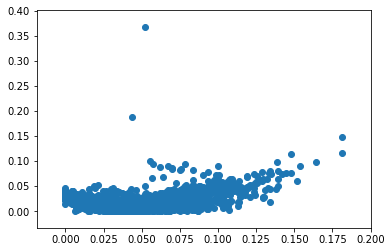

In [47]:
error_linear_svr=abs(Y_test-linear_svr_preds)
plt.scatter(x=Y_test,y=error_linear_svr);

In [48]:
MAE_linear_svr=MAE(y_true=Y_test,y_pred=linear_svr_preds)
print("El MAE del modelo linear_svr es:",MAE_linear_svr)

El MAE del modelo linear_svr es: 0.01780876717822207


In [49]:
((MAE_linear_svr/MAE_dummy)-1)*100

-22.421016638519998

<font color='brown'>En el gráfico podemos ver el error de las predicciones del modelo linear_svr con respecto al valor real (Y_test). El MAE del modelo linear_svr es 0.01780876717822207, un 22.42% menor que el del modelo dummy, por lo que **el modelo linear_svr predice mejor que el dummy**.
    
Vamos a comprobar si existe algún municipio cuyo valor sea la media o un valor cercano:  
Vamos a comprobar el nivel de acierto o casi acierto del modelo teniendo en cuenta el mismo margen de error que en el modelo dummy:</font>

In [50]:
aciertos_linear_svr=error_linear_svr==0
print("El modelo linear_svr ha acertado la tasa de paro en:",error_linear_svr[aciertos_linear_svr].shape[0],"municipios")

El modelo linear_svr ha acertado la tasa de paro en: 0 municipios


In [51]:
casi_aciertos_linear_svr=error_linear_svr<0.001
print("El modelo linear_svr ha acertado la tasa de paro con un margen de error de 0.001 en:",
      error_linear_svr[casi_aciertos_linear_svr].shape[0],"municipios")

El modelo linear_svr ha acertado la tasa de paro con un margen de error de 0.001 en: 83 municipios


<font color='brown'>Al igual que el modelo dummy, no ha acertado ninguna tasa de paro, sin embargo, con el mismo margen de error usado en el modelo dummy, el modelo linear_svr ha estado cerca de predecir correctamente la tasa de paro en 83 municipios, frente a los 79 del modelo dummy.</font>

In [52]:
filename = './linear_svr_preds.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[linear_svr_preds.index], linear_svr_preds], axis=1),
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,
                       unemploy_col=linear_svr_preds.name if linear_svr_preds.name is not None else 0,
                       cmap=color_range, coms=coms, provs=provs,
                       filename=filename)

In [53]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>Visualmente, vemos que **el modelo no predice correctamente**, ya que, aunque es cierto que en el mapa con los valores reales se observa una mayor tasa de paro hacía al sur del país, es decir, cuando la feature latitud disminuye, en este caso ese descenso es mucho mayor. También se puede ver que en el centro de la meseta la tasa de paro es menor, siendo cada vez más alta según vamos al este y al oeste, al igual que con latitud, aumentando en exceso.  **Los casos más claros son las Islas Canarias**, que se encuentran más al sur y más al oeste del país, viendo como su tasa de paro es la más alta de todas la predicciones **y Madrid y Barcelona**, cuyas tasas de paro superan el límite de la leyenda que se había ajustado a los valores reales, llegando Madrid a tener una tasa de paro de más del 40%.</font>

Let us try to **interpret what the resulting SVM is doing**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Explain what the model obtained is doing. What is the intercept and why is it that? What is the importance of each feature? Which features have a positive (i.e., making unemployment bigger) or a negative (making it smaller) effect on unemployment? Does this agree with your intuition about the problem?
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    The intercept (<i>b</i> in our formulas) is stored in the <i>intercept_</i> attribute of the model, whereas the weight vector (<i>w</i> in our formulas) is kept in the <i>coef_</i> attribute.
</td></tr>
</table>

<font color='brown'>El modelo trata de determinar el hiperplano que mejor se ajuste a nuestro datos, reduciendo el error para las features dadas. Este plano sigue la siguiente función para cada feature:
$y=wx+b+\epsilon$, siendo w los coeficientes que indican la importancia de cada feature, b el intersecto y $\epsilon$ el error propio del modelo al ser insensitive loss.<font>

In [54]:
mejor_modelo= gs_linear_svr.best_estimator_.named_steps["linear_svr"]
intercept= mejor_modelo.intercept_
coeficiente= mejor_modelo.coef_
features=X_train.columns.tolist()
tabla_coef=pd.DataFrame(coeficiente).T
tabla_coef.columns=[features]

In [55]:
print("El intercepto es:",intercept)
print("Los coeficientes son:")
tabla_coef

El intercepto es: [0.04561323]
Los coeficientes son:


,lat,lon,alt,habitantes
0,-0.013106,-0.006682,-0.009403,0.002813


In [56]:
print("La media de Y_train es:",stats.mean(Y_train))
print("El epsilon-insensitive es: ", best_epsilon_linear_svr)

La media de Y_train es: 0.04729103643639436
El epsilon-insensitive es:  0.01


<font color='brown'>Para calcular el intersecto, las features no intervienen en la función, es decir todos los coeficientes son 0, por lo que $y=b+\epsilon$. Al usar la minimización del error cuadrático, que trata de minimizar la desviación de la media, si las features no tienen relevancia, es decir, $w=0$, "y" es la media de las predicciones, por eso "b" es la media de las predicciones del ratio de paro, aproximadamente, ya que también hay que tener en cuenta $\epsilon$, que es el error propio del modelo al ser loss-insensitive.

Observamos que la feature que más esfecto tiene en el resultado es "latitud", con una "w" negativa, es decir, cuando la latitud aumenta el ratio de paro baja. Según el mapa "true_vals", era de esperar que la latitud tuviera una "w" negativa, ya que se observaba un mayor ratio de paro hacia el sur del país.

La "longitud" y la "altitud" también tienen un coeficiente negativo, pero menor a la "latitud", con lo que su efecto también es menor en la predicción.

Los "habitantes" es la única feature con una "w" positiva, es decir, según aumenta el ratio de paro también aumenta, siendo, sin embargo la que menos efecto tiene sobre la predicción.</font>

Fine, but this is for a linear SVM. Let us **check if we can do better with a non-linear SVM**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Train a <b>non-linear SVR with the RBF kernel</b>, tuning its hyperparameters with cross-validation.
 </td></tr>
</table>

In [57]:
gammas= np.logspace(-5, 4, 10)
Cs_2= np.logspace(-3, 0, 4)
epsilons_2= np.logspace(-3, 0, 4)

In [58]:
#Pipeline con tratamiento de datos y modelo:
modelo2=Pipeline(steps=[("scaler",StandardScaler()), ("rbf_svr", SVR(kernel="rbf"))])

#Grid de parámetros:
grid_rbf_svr= {"rbf_svr__C": Cs_2,
               "rbf_svr__gamma": gammas,
               "rbf_svr__epsilon": epsilons_2}

#Grid seach:
gs_rbf_svr=GridSearchCV(modelo2,
                        grid_rbf_svr,
                        cv=5,
                        scoring="r2",
                        verbose=1,
                        n_jobs=-1)

In [59]:
gs_rbf_svr.fit(X_train,Y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 604 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rbf_svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'rbf_svr__C': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'rbf_svr__epsilon': array([0.001, 0.01 , 0.1  , 1.   ]

In [60]:
best_acc_rbf_svr=gs_rbf_svr.best_score_
best_C_rbf_svr=gs_rbf_svr.best_params_["rbf_svr__C"]
best_epsilon_rbf_svr=gs_rbf_svr.best_params_["rbf_svr__epsilon"]
best_gamma_rbf_svr=gs_rbf_svr.best_params_["rbf_svr__gamma"]
best_model_rbf_svr=gs_rbf_svr.best_estimator_

In [61]:
print("Best C =", str(best_C_rbf_svr))
print("Best Epsilon =", str(best_epsilon_rbf_svr))
print("Best Gamma =", str(best_gamma_rbf_svr))
print("Best R^2 on train =", str(best_acc_rbf_svr))
print("Best model =", str(best_model_rbf_svr))

Best C = 0.1
Best Epsilon = 0.01
Best Gamma = 1.0
Best R^2 on train = 0.568955340506234
Best model = Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rbf_svr',
                 SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
                     gamma=1.0, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


<font color='brown'>Los mejores hiperparámetros de nuestro modelo son:  
- C = 0.1
- epsilon = 0.01
- gamma = 1.0
- degree = 3
- max_iter = -1
- shrinking = True
- tol = 0.001

El mejor R^2 en train = 0.568955340506234</font>

Non-linearity should not give us a worse model, but does it yield a better one?

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Measure scores and create the map with the non-linear SVR predictions. Did things improve?
 </td></tr>
</table>

In [62]:
rbf_svr_preds=best_model_rbf_svr.predict(X_test)

In [63]:
rbf_svr_preds=pd.Series(data=rbf_svr_preds, index=X_test.index)
rbf_svr_preds.sort_values(0,ascending=False)

com_aut        prov                    mun                      
Andalucía      Cádiz                   Puerto de Santa María, El    0.126324
                                       San Roque                    0.120729
                                       Rota                         0.119943
                                       Arcos de la Frontera         0.119339
Canarias       Santa Cruz de Tenerife  Güímar                       0.111859
                                                                      ...   
Aragón         Zaragoza                Aldehuela de Liestos         0.010156
                                       Berdejo                      0.009887
                                       Sisamón                      0.009724
Castilla León  Soria                   Reznos                       0.009703
                                       Carabantes                   0.009334
Length: 2434, dtype: float64

In [64]:
best_model_score_rbf_svr=best_model_rbf_svr.score(X_test,Y_test)
print("Best model score (R^2) =", str(best_model_score_rbf_svr))

Best model score (R^2) = 0.5825184011562825


In [65]:
((best_acc_rbf_svr/best_model_score_rbf_svr)-1)*100

-2.3283488767266824

<font color='brown'>Observamos que el R^2 en train (0.5690) es menor que el obtenido en test (0.5825), pero en sólo un 2.33%, por lo que **no podemos decir que el modelo esté sobreajustado**. **El R^2 obtenido en este modelo rbf_svr mejora los resultados del modelo linear_svr**, aunque sus predicciones no son muy exactas.  
Vamos a comprobar visualmente como predice el modelo rbf_svr calculando el error absoluto entre las Y reales y las Y predichas. También calcularemos el MAE (error absoluto medio) de este modelo:</font>

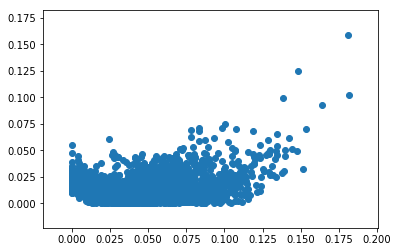

In [66]:
error_rbf_svr=abs(Y_test-rbf_svr_preds)
plt.scatter(x=Y_test,y=error_rbf_svr);

In [67]:
MAE_rbf_svr=MAE(y_true=Y_test,y_pred=rbf_svr_preds)
print("El MAE del modelo rbf_svr es:",MAE_rbf_svr)

El MAE del modelo rbf_svr es: 0.013816646888683668


In [68]:
((MAE_rbf_svr/MAE_linear_svr)-1)*100

-22.41660104591784

<font color='brown'>En el gráfico podemos ver el error de las predicciones del modelo linear_svr con respecto al valor real (Y_test). El MAE del modelo linear_svr es 0.013816646888683668, un 22.42% menor que el del modelo liner_svr, por lo que **el modelo rbf_svr predice mejor que el linear_svr**.
    
Vamos a comprobar si existe algún municipio cuyo valor sea la media o un valor cercano:  
Vamos a comprobar el nivel de acierto o casi acierto del modelo teniendo en cuenta el mismo margen de error que en los modelos anteriores:</font>

In [69]:
aciertos_rbf_svr=error_rbf_svr==0
print("El modelo rbf_svr ha acertado la tasa de paro en:",error_rbf_svr[aciertos_rbf_svr].shape[0],"municipios")

El modelo rbf_svr ha acertado la tasa de paro en: 0 municipios


In [70]:
casi_aciertos_rbf_svr=error_rbf_svr<0.001
print("El modelo rbf_svr ha acertado la tasa de paro con un margen de error de 0.001 en:",
      error_rbf_svr[casi_aciertos_rbf_svr].shape[0],"municipios")

El modelo rbf_svr ha acertado la tasa de paro con un margen de error de 0.001 en: 137 municipios


<font color='brown'>Al igual que en los modelos anteriores, no ha acertado ninguna tasa de paro, sin embargo, para el mismo margen de error usado en los anteriores modelos, el modelo rbf_svr ha estado cerca de predecir correctamente la tasa de paro en 137 municipios, frente a los 83 del modelo linear_svr.</font>

In [71]:
filename = './rbf_svr_preds.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[rbf_svr_preds.index], rbf_svr_preds], axis=1),
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,
                       unemploy_col=rbf_svr_preds.name if rbf_svr_preds.name is not None else 0,
                       cmap=color_range, coms=coms, provs=provs,
                       filename=filename)

In [72]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>Visualmente, vemos que **el modelo mejora con respecto al linear_svr**, se sigue observando una mayor tasa de paro hacía al sur del país y también el aumento de tasa de paro al este y oeste de la meseta, sin embargo, en este caso es menos excesivo, viéndose resultados de paro no tan bajos como anteriormente. Ahora las Islas Canarias, tienen un mayor parecido al valor real.</font>

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Try to explain the behaviour of the non-linear model obtained.
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
It is much more difficult to interpret a non-linear SVM than a linear one. You can examine the support vectors, available in the attributes <i>support_</i>, <i>support_vectors_</i> and <i>dual_coef_</i>, to see which municipalities are considered as the most and least representative of each class. Another idea is to check and detect trends in municipalities unemployment being underestimated, being overestimated or being accurately predicted.
</td></tr>
</table>

<font color='brown'>NaN</font>

### 3.2. Using previous years (2006-2017)

So far we have predicted unemployment rates based solely on municipality fixed characteristics (namely coordinates, altitude and population). Fortunately, we also have the unemployment figures for years 2006-2017, so that **we can use unemployment in previous years to try to predict what will happen next**, in a time series fashion:

In [73]:
prev_years = list(range(2006, 2018))    # does not include 2018
prev_years

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Read the unemployment data from the <i>./data</i> folder for years 2006-2017 (both 2006 and 2017 included). You should concatenate the data for all years in a single dataframe called <i>unempl_2006_2017</i>.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
    The function <i>read_unemployment</i> from the <i>utils</i> module will help you to load the unemployment figures for a single year, as was done above for year 2018. Each year has a separate CSV file, so you should call <i>read_unemployment</i> once for each file. Then use pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html">concat</a> method to store everything in a single dataframe.
</td></tr>
</table>

In [74]:
csv_files = glob.glob('./data/Paro_por_municipios_*.csv')
csv_files.pop()
csv_files

['./data\\Paro_por_municipios_2006.csv',
 './data\\Paro_por_municipios_2007.csv',
 './data\\Paro_por_municipios_2008.csv',
 './data\\Paro_por_municipios_2009.csv',
 './data\\Paro_por_municipios_2010.csv',
 './data\\Paro_por_municipios_2011.csv',
 './data\\Paro_por_municipios_2012.csv',
 './data\\Paro_por_municipios_2013.csv',
 './data\\Paro_por_municipios_2014.csv',
 './data\\Paro_por_municipios_2015.csv',
 './data\\Paro_por_municipios_2016.csv',
 './data\\Paro_por_municipios_2017.csv']

In [75]:
unempl_2006 = utils.read_unemployment('./data/Paro_por_municipios_2006.csv')
num_muns = len(unempl_2006.index.unique())
print(f'unempl_2006 = {len(unempl_2006)} unemployment data from {num_muns} municipalities')

unempl_2007 = utils.read_unemployment('./data/Paro_por_municipios_2007.csv')
num_muns = len(unempl_2007.index.unique())
print(f'unempl_2007 = {len(unempl_2007)} unemployment data from {num_muns} municipalities')

unempl_2008 = utils.read_unemployment('./data/Paro_por_municipios_2008.csv')
num_muns = len(unempl_2008.index.unique())
print(f'unempl_2008 = {len(unempl_2008)} unemployment data from {num_muns} municipalities')

unempl_2009 = utils.read_unemployment('./data/Paro_por_municipios_2009.csv')
num_muns = len(unempl_2009.index.unique())
print(f'unempl_2009 = {len(unempl_2009)} unemployment data from {num_muns} municipalities')

unempl_2010 = utils.read_unemployment('./data/Paro_por_municipios_2010.csv')
num_muns = len(unempl_2010.index.unique())
print(f'unempl_2010 = {len(unempl_2010)} unemployment data from {num_muns} municipalities')

unempl_2011 = utils.read_unemployment('./data/Paro_por_municipios_2011.csv')
num_muns = len(unempl_2011.index.unique())
print(f'unempl_2011 = {len(unempl_2011)} unemployment data from {num_muns} municipalities')

unempl_2012 = utils.read_unemployment('./data/Paro_por_municipios_2012.csv')
num_muns = len(unempl_2012.index.unique())
print(f'unempl_2012 = {len(unempl_2012)} unemployment data from {num_muns} municipalities')

unempl_2013 = utils.read_unemployment('./data/Paro_por_municipios_2013.csv')
num_muns = len(unempl_2013.index.unique())
print(f'unempl_2013 = {len(unempl_2013)} unemployment data from {num_muns} municipalities')

unempl_2014 = utils.read_unemployment('./data/Paro_por_municipios_2014.csv')
num_muns = len(unempl_2014.index.unique())
print(f'unempl_2014 = {len(unempl_2014)} unemployment data from {num_muns} municipalities')

unempl_2015 = utils.read_unemployment('./data/Paro_por_municipios_2015.csv')
num_muns = len(unempl_2015.index.unique())
print(f'unempl_2015 = {len(unempl_2015)} unemployment data from {num_muns} municipalities')

unempl_2016 = utils.read_unemployment('./data/Paro_por_municipios_2016.csv')
num_muns = len(unempl_2016.index.unique())
print(f'unempl_2016 = {len(unempl_2016)} unemployment data from {num_muns} municipalities')

unempl_2017 = utils.read_unemployment('./data/Paro_por_municipios_2017.csv')
num_muns = len(unempl_2017.index.unique())
print(f'unempl_2017 = {len(unempl_2017)} unemployment data from {num_muns} municipalities')

unempl_2006 = 97404 unemployment data from 8117 municipalities
unempl_2007 = 97404 unemployment data from 8117 municipalities
unempl_2008 = 97404 unemployment data from 8117 municipalities
unempl_2009 = 97404 unemployment data from 8117 municipalities
unempl_2010 = 97404 unemployment data from 8117 municipalities
unempl_2011 = 97404 unemployment data from 8117 municipalities
unempl_2012 = 97404 unemployment data from 8117 municipalities
unempl_2013 = 97404 unemployment data from 8117 municipalities
unempl_2014 = 97404 unemployment data from 8117 municipalities
unempl_2015 = 97404 unemployment data from 8117 municipalities
unempl_2016 = 97512 unemployment data from 8126 municipalities
unempl_2017 = 97512 unemployment data from 8126 municipalities


In [76]:
for i in csv_files:
    utils.read_unemployment('./data/Paro_por_municipios_2017.csv')
num_muns = len(unempl_2017.index.unique())
print(f'unempl_2017 = {len(unempl_2017)} unemployment data from {num_muns} municipalities')
    

unempl_2017 = 97512 unemployment data from 8126 municipalities


In [77]:
unempl_2006_2017=pd.concat([unempl_2006,unempl_2007,unempl_2008,unempl_2009,unempl_2010,unempl_2011,
           unempl_2012,unempl_2013,unempl_2014,unempl_2015,unempl_2016,unempl_2017])

unempl_2006_2017

año  mes  parados
com_aut   prov     mun                          
Andalucía Almería  Abla       2006    1       56
                   Abrucena   2006    1       50
                   Adra       2006    1      775
                   Albánchez  2006    1       14
                   Alboloduy  2006    1       24
...                            ...  ...      ...
La Rioja  La Rioja Zarratón   2017   12       10
                   Zarzosa    2017   12        0
                   Zorraquín  2017   12        2
Ceuta     Ceuta    Ceuta      2017   12    11843
Melilla   Melilla  Melilla    2017   12     9397

[1169064 rows x 3 columns]

**For each municipality, we expect to have 144 observations** (12 years, 12 months each). For example, again taking Abla in Almería the last 15 are:

In [78]:
sub = unempl_2006_2017.xs(key='Abla', level=utils.MUN_FIELD, drop_level=False)
print(len(sub))
sub.tail(15)      # all records whose mun is Abla, keeping index intact

144


año  mes  parados
com_aut   prov    mun                     
Andalucía Almería Abla  2016   10       95
                  Abla  2016   11      102
                  Abla  2016   12       83
                  Abla  2017    1       77
                  Abla  2017    2       79
                  Abla  2017    3       87
                  Abla  2017    4       90
                  Abla  2017    5       85
                  Abla  2017    6       83
                  Abla  2017    7       81
                  Abla  2017    8       88
                  Abla  2017    9       82
                  Abla  2017   10       88
                  Abla  2017   11       81
                  Abla  2017   12       83

**Again we can take yearly means** for each year:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Calculate unemployment yearly means for each year 2006-2017 and each municipality, in a similar way that was done previously for year 2018.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
Since there are several years now, you should also group by year besides grouping by community, province and municipality.
 </td></tr>
</table>

In [79]:
unempl_2006_2017_means=unempl_2006_2017.pivot_table(values="parados",
                                                    index=unempl_2006_2017.index.names,
                                                    columns="año", aggfunc="mean")

unempl_2006_2017_means

año                                           2006         2007         2008  \
com_aut   prov              mun                                                
Andalucía Almería           Abla         63.166667    48.583333    64.416667   
                            Abrucena     44.833333    38.500000    52.833333   
                            Adra       1085.083333  1158.500000  1708.583333   
                            Alboloduy    23.833333    25.666667    25.666667   
                            Albox       340.000000   360.500000   499.916667   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     1339.333333  1265.666667  1675.500000   
                            Yesa, La      5.583333     3.916667     3.916667   
                            Yátova       58.166667    59.500000    81.500000   
                            Zarra        13.500000    12.916667    16.833333   
                            Ènova, l'    41.583333    34.416667    48.583333   

año                                           2009         2010         2011  \
com_aut   prov              mun                                                
Andalucía Almería           Abla         73.000000    94.250000    99.666667   
                            Abrucena     56.583333    77.916667    73.166667   
                            Adra       2476.083333  2951.333333  3036.583333   
                            Alboloduy    31.166667    36.833333    40.833333   
                            Albox       767.416667   900.333333   938.000000   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     2575.916667  2943.333333  3150.416667   
                            Yesa, La      7.583333    15.666667     9.416667   
                            Yátova      161.250000   187.166667   188.166667   
                            Zarra        20.416667    20.500000    26.500000   
                            Ènova, l'    78.250000    89.500000    83.583333   

año                                           2012         2013         2014  \
com_aut   prov              mun                                                
Andalucía Almería           Abla        113.583333   125.083333   126.583333   
                            Abrucena     84.833333    72.916667    77.333333   
                            Adra       3132.333333  2993.833333  3033.916667   
                            Alboloduy    53.666667    53.250000    55.416667   
                            Albox      1002.500000  1055.416667  1022.416667   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     3489.666667  3611.916667  3449.000000   
                            Yesa, La     17.666667    13.916667    13.750000   
                            Yátova      213.250000   228.833333   217.250000   
                            Zarra        28.333333    30.916667    25.083333   
                            Ènova, l'    92.833333    93.916667    90.583333   

año                                           2015         2016         2017  
com_aut   prov              mun                                               
Andalucía Almería           Abla        106.333333    95.416667    83.666667  
                            Abrucena     81.500000    79.500000    74.666667  
                            Adra       3065.916667  2703.000000  2433.750000  
                            Alboloduy    47.333333    46.166667    35.416667  
                            Albox      1013.833333   902.250000   808.916667  
...                                            ...          ...          ...  
Valencia  Valencia/València Xàtiva     3164.833333  2903.166667  2652.250000  
                            Yesa, La     13.666667    10.916667    12.083333  
                            Yátova      202.166667   173.250000   145.916667  
        

And **transform these raw means to rates**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create an <i>X2</i> matrix with the mean unemployment rates for the different years. This matrix should have one row for each municipality and one column for each year.
 </td></tr>
</table>

<table align="left">
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
You have to do two things: 
<ol>
<li> Join with populations and divide.
<li> Transpose from column to row format. 
</ol> 
1) is basically done as for 2018 (joining on just the first 3 levels, omitting the year), while 2) is easily tackled with the <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html">pivot</a> method.
</td></tr>
</table>

In [80]:
unempl_2006_2017_index_mun= unempl_2006_2017_means.merge(muns_population, on=["com_aut","prov","mun"])
unempl_2006_2017_index_mun

2006         2007         2008  \
com_aut   prov              mun                                                
Andalucía Almería           Abla         63.166667    48.583333    64.416667   
                            Abrucena     44.833333    38.500000    52.833333   
                            Adra       1085.083333  1158.500000  1708.583333   
                            Alboloduy    23.833333    25.666667    25.666667   
                            Albox       340.000000   360.500000   499.916667   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     1339.333333  1265.666667  1675.500000   
                            Yesa, La      5.583333     3.916667     3.916667   
                            Yátova       58.166667    59.500000    81.500000   
                            Zarra        13.500000    12.916667    16.833333   
                            Ènova, l'    41.583333    34.416667    48.583333   

                                              2009         2010         2011  \
com_aut   prov              mun                                                
Andalucía Almería           Abla         73.000000    94.250000    99.666667   
                            Abrucena     56.583333    77.916667    73.166667   
                            Adra       2476.083333  2951.333333  3036.583333   
                            Alboloduy    31.166667    36.833333    40.833333   
                            Albox       767.416667   900.333333   938.000000   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     2575.916667  2943.333333  3150.416667   
                            Yesa, La      7.583333    15.666667     9.416667   
                            Yátova      161.250000   187.166667   188.166667   
                            Zarra        20.416667    20.500000    26.500000   
                            Ènova, l'    78.250000    89.500000    83.583333   

                                              2012         2013         2014  \
com_aut   prov              mun                                                
Andalucía Almería           Abla        113.583333   125.083333   126.583333   
                            Abrucena     84.833333    72.916667    77.333333   
                            Adra       3132.333333  2993.833333  3033.916667   
                            Alboloduy    53.666667    53.250000    55.416667   
                            Albox      1002.500000  1055.416667  1022.416667   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     3489.666667  3611.916667  3449.000000   
                            Yesa, La     17.666667    13.916667    13.750000   
                            Yátova      213.250000   228.833333   217.250000   
                            Zarra        28.333333    30.916667    25.083333   
                            Ènova, l'    92.833333    93.916667    90.583333   

                                              2015         2016         2017  \
com_aut   prov              mun                                                
Andalucía Almería           Abla        106.333333    95.416667    83.666667   
                            Abrucena     81.500000    79.500000    74.666667   
                            Adra       3065.916667  2703.000000  2433.750000   
                            Alboloduy    47.333333    46.166667    35.416667   
                            Albox      1013.833333   902.250000   808.916667   
...                                            ...          ...          ...   
Valencia  Valencia/València Xàtiva     3164.833333  2903.166667  2652.250000   
                            Yesa, La     13.666667    10.916667    12.083333   
                            Yátova      202.166667   173.250000   145.916667   
                            Zarra        20

In [81]:
"""No ejecutar más de una vez este código, porque realizaría de nuevo la división cada vez que se ejecuta,
haciéndose cada vez más pequeño el ratio de paro."""
for i in prev_years:
    unempl_2006_2017_index_mun[i]=unempl_2006_2017_index_mun[i]/unempl_2006_2017_index_mun.habitantes

In [82]:
unempl_2006_2017_index_mun

2006      2007      2008      2009  \
com_aut   prov              mun                                                 
Andalucía Almería           Abla       0.041999  0.032303  0.042830  0.048537   
                            Abrucena   0.033433  0.028710  0.039398  0.042195   
                            Adra       0.044520  0.047532  0.070101  0.101591   
                            Alboloduy  0.035361  0.038081  0.038081  0.046241   
                            Albox      0.030417  0.032251  0.044723  0.068654   
...                                         ...       ...       ...       ...   
Valencia  Valencia/València Xàtiva     0.045577  0.043070  0.057017  0.087658   
                            Yesa, La   0.021474  0.015064  0.015064  0.029167   
                            Yátova     0.026451  0.027058  0.037062  0.073329   
                            Zarra      0.024501  0.023442  0.030551  0.037054   
                            Ènova, l'  0.040848  0.033808  0.047724  0.076866   

                                           2010      2011      2012      2013  \
com_aut   prov              mun                                                 
Andalucía Almería           Abla       0.062666  0.066268  0.075521  0.083167   
                            Abrucena   0.058103  0.054561  0.063261  0.054375   
                            Adra       0.121090  0.124588  0.128517  0.122834   
                            Alboloduy  0.054649  0.060584  0.079624  0.079006   
                            Albox      0.080545  0.083915  0.089685  0.094419   
...                                         ...       ...       ...       ...   
Valencia  Valencia/València Xàtiva     0.100161  0.107208  0.118753  0.122913   
                            Yesa, La   0.060256  0.036218  0.067949  0.053526   
                            Yátova     0.085114  0.085569  0.096976  0.104062   
                            Zarra      0.037205  0.048094  0.051422  0.056110   
                            Ènova, l'  0.087917  0.082105  0.091192  0.092256   

                                           2014      2015      2016      2017  \
com_aut   prov              mun                                                 
Andalucía Almería           Abla       0.084164  0.070700  0.063442  0.055629   
                            Abrucena   0.057668  0.060776  0.059284  0.055680   
                            Adra       0.124479  0.125792  0.110901  0.099854   
                            Alboloduy  0.082221  0.070227  0.068497  0.052547   
                            Albox      0.091467  0.090699  0.080717  0.072367   
...                                         ...       ...       ...       ...   
Valencia  Valencia/València Xàtiva     0.117369  0.107699  0.098794  0.090256   
                            Yesa, La   0.052885  0.052564  0.041987  0.046474   
                            Yátova     0.098795  0.091936  0.078786  0.066356   
                            Zarra      0.045523  0.037659  0.038717  0.041289   
                            Ènova, l'  0.088982  0.085134  0.065242  0.056074   

                                            lat       lon        alt  \
com_aut   prov              mun                                        
Andalucía Almería           Abla       37.14114 -2.780104  871.16840   
                            Abrucena   37.13305 -2.797098  976.93870   
                            Adra       36.74807 -3.022522   10.97898   
                            Alboloduy  37.03319 -2.621750  388.43460   
                            Albox      37.38979 -2.147483  426.42680   
...                                         ...       ...        ...   
Valencia  Valencia/València Xàtiva     38.98887 -0.515614  118.28640   
                            Yesa, La   39.49916 -0.426125   52.28455   
                            Yátova     39.38500 -0.808174  441.81140   
                            Zarra      39.09138 -1.075068  576.03660   
                 

In [83]:
X2=unempl_2006_2017_index_mun[prev_years]
X2

2006      2007      2008      2009  \
com_aut   prov              mun                                                 
Andalucía Almería           Abla       0.041999  0.032303  0.042830  0.048537   
                            Abrucena   0.033433  0.028710  0.039398  0.042195   
                            Adra       0.044520  0.047532  0.070101  0.101591   
                            Alboloduy  0.035361  0.038081  0.038081  0.046241   
                            Albox      0.030417  0.032251  0.044723  0.068654   
...                                         ...       ...       ...       ...   
Valencia  Valencia/València Xàtiva     0.045577  0.043070  0.057017  0.087658   
                            Yesa, La   0.021474  0.015064  0.015064  0.029167   
                            Yátova     0.026451  0.027058  0.037062  0.073329   
                            Zarra      0.024501  0.023442  0.030551  0.037054   
                            Ènova, l'  0.040848  0.033808  0.047724  0.076866   

                                           2010      2011      2012      2013  \
com_aut   prov              mun                                                 
Andalucía Almería           Abla       0.062666  0.066268  0.075521  0.083167   
                            Abrucena   0.058103  0.054561  0.063261  0.054375   
                            Adra       0.121090  0.124588  0.128517  0.122834   
                            Alboloduy  0.054649  0.060584  0.079624  0.079006   
                            Albox      0.080545  0.083915  0.089685  0.094419   
...                                         ...       ...       ...       ...   
Valencia  Valencia/València Xàtiva     0.100161  0.107208  0.118753  0.122913   
                            Yesa, La   0.060256  0.036218  0.067949  0.053526   
                            Yátova     0.085114  0.085569  0.096976  0.104062   
                            Zarra      0.037205  0.048094  0.051422  0.056110   
                            Ènova, l'  0.087917  0.082105  0.091192  0.092256   

                                           2014      2015      2016      2017  
com_aut   prov              mun                                                
Andalucía Almería           Abla       0.084164  0.070700  0.063442  0.055629  
                            Abrucena   0.057668  0.060776  0.059284  0.055680  
                            Adra       0.124479  0.125792  0.110901  0.099854  
                            Alboloduy  0.082221  0.070227  0.068497  0.052547  
                            Albox      0.091467  0.090699  0.080717  0.072367  
...                                         ...       ...       ...       ...  
Valencia  Valencia/València Xàtiva     0.117369  0.107699  0.098794  0.090256  
                            Yesa, La   0.052885  0.052564  0.041987  0.046474  
                            Yátova     0.098795  0.091936  0.078786  0.066356  
                            Zarra      0.045523  0.037659  0.038717  0.041289  
                            Ènova, l'  0.088982  0.085134  0.065242  0.056074  

[8111 rows x 12 columns]

Verify that your matrix is correct:

In [84]:
assert(len(X2) == len(X) and (len(X2.columns) == len(prev_years)))   # same municipalities than before, 1 column for each year

**Split these new patterns**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Split <i>X2</i> into training and test sets, so that you obtain variables <i>X2_train</i> and <i>X2_test</i>.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Same as before, do not call <i>train_test_split</i> again. Features in <i>X</i> and <i>X2</i> are different, but municipalities in train and test do not change.
 </td></tr>
</table>

In [85]:
X2_train=X2.loc[Y_train.index]
X2_test=X2.loc[Y_test.index]

Training and test municipalities should be the same as before:

In [86]:
assert(all(X2_train.index == X_train.index) and all(X2_train.columns == X2.columns) and     # same index, same columns for training
      all(X2_test.index == X_test.index) and all(X2_test.columns == X2_train.columns))     # and for testing

**Train and predict with a linear SVR with the new dataset**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Tune a <b>linear SVR</b>, measure its score on test, plot its predictions and compare with the ones you got for the baseline linear SVR. Are these predictions better? By how much?
 </td></tr>
</table>

In [87]:
Cs_3= np.logspace(-3, 4, 8)
epsilons_3= np.logspace(-4, 4, 9)

In [88]:
#Pipeline con tratamiento de datos y modelo:
modelo3=Pipeline(steps=[("scaler",StandardScaler()), ("linear_svr_year", LinearSVR())])

#Grid de parámetros:
grid_linear_svr_year= {"linear_svr_year__C": Cs,
                  "linear_svr_year__epsilon": epsilons,
                  "linear_svr_year__loss": ["epsilon_insensitive","square_epsilon_insensitive"],
                  "linear_svr_year__fit_intercept": [True,False],
                  "linear_svr_year__dual": [False,True],
                  "linear_svr_year__random_state": [RANDOM_STATE]}

#Grid seach:
gs_linear_svr_year=GridSearchCV(modelo3,
                                grid_linear_svr_year,
                                cv=5,
                                scoring="r2",
                                verbose=1,
                                n_jobs=-1)

In [89]:
gs_linear_svr_year.fit(X2_train,Y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1180 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1900 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linear_svr_year',
                                        LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  loss='epsilon_insensitive',
                                                  max_iter=1000,
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated'...
        

In [90]:
best_acc_linear_svr_year=gs_linear_svr_year.best_score_
best_C_linear_svr_year=gs_linear_svr_year.best_params_["linear_svr_year__C"]
best_epsilon_linear_svr_year=gs_linear_svr_year.best_params_["linear_svr_year__epsilon"]
best_model_linear_svr_year=gs_linear_svr_year.best_estimator_

In [91]:
print("Best C =", str(best_C_linear_svr_year))
print("Best Epsilon =", str(best_epsilon_linear_svr_year))
print("Best R^2 on train =", str(best_acc_linear_svr_year))
print("Best model =", str(best_model_linear_svr_year))

Best C = 0.001
Best Epsilon = 0.001
Best R^2 on train = 0.9341202272728971
Best model = Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svr_year',
                 LinearSVR(C=0.001, dual=True, epsilon=0.001,
                           fit_intercept=True, intercept_scaling=1.0,
                           loss='epsilon_insensitive', max_iter=1000,
                           random_state=42, tol=0.0001, verbose=0))],
         verbose=False)


<font color='brown'>Los mejores hiperparámetros de nuestro modelo son:  
- C = 0.001
- epsilon = 0.001
- dual = True
- fit_intercet = True,
- intercept_scaling = 1.0
- loss = 'epsilon_insensitive'
- max_iter = 1000
- tol = 0.0001

El mejor R^2 en train = 0.9341202272728971</font>

In [92]:
linear_svr_year_preds=best_model_linear_svr_year.predict(X2_test)

In [93]:
linear_svr_year_preds=pd.Series(data=linear_svr_year_preds, index=X2_test.index)
linear_svr_year_preds.sort_values(0,ascending=False)

com_aut        prov      mun                      
Castilla León  Burgos    Palacios de Riopisuerga      0.177513
Extremadura    Cáceres   Saucedilla                   0.174692
                         Huélaga                      0.161167
Andalucía      Cádiz     Arcos de la Frontera         0.151228
Extremadura    Badajoz   Quintana de la Serena        0.140141
                                                        ...   
Castilla León  Soria     Aldehuela de Periáñez       -0.000918
La Rioja       La Rioja  Torrecilla sobre Alesanco   -0.000934
Castilla León  Soria     Cirujales del Río           -0.000964
La Rioja       La Rioja  Villarroya                  -0.001028
Aragón         Zaragoza  Longás                      -0.001176
Length: 2434, dtype: float64

In [94]:
best_model_score_linear_svr_year=best_model_linear_svr_year.score(X2_test,Y_test)
print("Best model score (R^2) =", str(best_model_score_linear_svr_year))

Best model score (R^2) = 0.9415670887385296


In [95]:
((best_acc_linear_svr_year/best_model_score_linear_svr_year)-1)*100

-0.7909007817604841

<font color='brown'>Observamos que el R^2 en train (0.9341) es ligeramente menor que el obtenido en test (0.9416), 0.79%, por lo que el modelo no está sobreajustado ni subajustado. **Con las features de ratio de paro anual hemos mejorado ampliamente el R^2 del modelo rbf_svr con las features de latitud, longitud, altitud y habitantes**, el mejor con esas features. **Este modelo linear_svr predice de forma muy ajustada la tasa de paro de los municipios**.  
Vamos a comprobar visualmente como predice el modelo linear_svr_year con las nuevas features, calculando el error absoluto entre las Y reales y las Y predichas por el modelo. También calcularemos el MAE (error absoluto medio) de este modelo:</font>

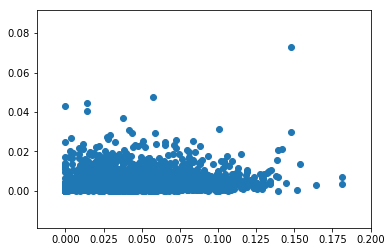

In [96]:
error_linear_svr_year=abs(Y_test-linear_svr_year_preds)
plt.scatter(x=Y_test,y=error_linear_svr_year);

In [97]:
MAE_linear_svr_year=MAE(y_true=Y_test,y_pred=linear_svr_year_preds)
print("El MAE del modelo linear_svr_year es:",MAE_linear_svr_year)

El MAE del modelo linear_svr_year es: 0.004756083553141547


In [98]:
((MAE_linear_svr_year/MAE_rbf_svr)-1)*100

-65.57715058175981

<font color='brown'>En el gráfico podemos ver el error de las predicciones del modelo linear_svr_year con respecto al valor real (Y_test). El MAE del modelo linear_svr_year es 0.004756083553141547, un 65.58% menor que el del modelo rbf_svr, que fue el mejor de los modelos con las features de latitud, longitud, altitud y habitantes, por lo que **el modelo linear_svr_year con las nuevas features predice mejor que el rbf_svr con las anteriores features**.
    
Vamos a comprobar si existe algún municipio cuyo valor sea la media o un valor cercano:  
Vamos a comprobar el nivel de acierto o casi acierto del modelo teniendo en cuenta el mismo margen de error que en los modelos anteriores:</font>

In [99]:
aciertos_linear_svr_year=error_linear_svr_year==0
print("El modelo linear_svr_year ha acertado la tasa de paro en:",
      error_linear_svr_year[aciertos_linear_svr_year].shape[0],"municipios")

El modelo linear_svr_year ha acertado la tasa de paro en: 0 municipios


In [100]:
casi_aciertos_linear_svr_year=error_linear_svr_year<0.001
print("El modelo linear_svr_year ha acertado la tasa de paro con un margen de error de 0.001 en:",
      error_linear_svr_year[casi_aciertos_linear_svr_year].shape[0],"municipios")

El modelo linear_svr_year ha acertado la tasa de paro con un margen de error de 0.001 en: 451 municipios


<font color='brown'>Al igual que en el resto de modelos, no ha acertado ninguna tasa de paro, si observamos, para el mismo margen de error usado en los anteriores modelos, el modelo linear_svr_year, con las nuevas features, ha estado cerca de predecir correctamente la tasa de paro en 451 municipios, frente a los 137 del modelo rbf_svr, que era el modelo con con las features anteriores que mayor acierto tuvo.</font>

In [101]:
filename = './linear_svr_year_preds.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[linear_svr_year_preds.index], linear_svr_year_preds], axis=1),
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,
                       unemploy_col=linear_svr_year_preds.name if linear_svr_year_preds.name is not None else 0,
                       cmap=color_range, coms=coms, provs=provs,
                       filename=filename)

In [102]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>**El parecido con el mapa de los valores reales es muy elevado, siendo difícil diferenciar ambos**. Se sigue observando una mayor tasa de paro hacía al sur del país, pero la predicción de la tasa de paro ya no es tan fuerte hacia el este y el oeste.</font>

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Explain what this new linear model is doing. Which do you think are the most relevant features now? Verify whether your intuition is correct or not.
 </td></tr>
</table>

<font color='brown'>El modelo, al igual que en el anterior modelo linear_svr, trata de determinar el hiperplano que mejor se ajuste a nuestras nuevas features, la tasa de paro anual desde 2006 hasta 2007.  
Este plano sigue la siguiente función para cada feature:
$y=wx+b+\epsilon$, siendo w los coeficientes que indican la importancia de cada feature, en este caso tendremos una para cada año (2006 hasta 2017), b el intersecto y $\epsilon$ el error propio del modelo al ser insensitive loss.<font>

In [103]:
mejor_modelo_linear_svr_year= gs_linear_svr_year.best_estimator_.named_steps["linear_svr_year"]
intercept_linear_svr_year= mejor_modelo_linear_svr_year.intercept_
coeficiente_linear_svr_year= mejor_modelo_linear_svr_year.coef_
features_linear_svr_year=X2_train.columns.tolist()
tabla_coef_linear_svr_year=pd.DataFrame(coeficiente_linear_svr_year).T
tabla_coef_linear_svr_year.columns=[features_linear_svr_year]

In [104]:
print("El intercepto es:",intercept_linear_svr_year)
print("Los coeficientes son:")
tabla_coef_linear_svr_year

El intercepto es: [0.04720735]
Los coeficientes son:


,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,-0.000903,0.000089,0.000672,-0.000487,0.000523,0.00057,0.000152,-0.00007,-0.000124,0.00191,-0.000533,0.026382


In [105]:
print("La media de Y_train es:",stats.mean(Y_train))
print("El epsilon-insensitive es: ", best_epsilon_linear_svr_year)

La media de Y_train es: 0.04729103643639436
El epsilon-insensitive es:  0.001


<font color='brown'>Al igual que en el modelo linear_svr con las antiguas features, nuestro intersecto es muy cercano a la media de las predicciones, por el mismo motivo que comentamos anteriormente.

Observamos que la feature que más esfecto tiene en el resultado es "2017", con una "w" positiva, es decir, provoca un descenso en el ratio de paro. Tiene sentido que sea la que tiene más importancia, ya que al ser la tasa de paro del año justo anterior, debería tener más influencia sobre la tasa de paro de 2018.  

El resto de años con una "w" positiva, es decir, cuando aumentan hacen descender la tasa de paro predicha, son 2007, 2008, 2010, 2011, 2012 y 2015.
    
El resto de años tienen una "w" negativa, es decir, cuando estas se hacen cada vez más pequeñas, hacen aumentar la tasa de paro predicha. Teniendo en cuenta que durante 2008 se inició una crisis mundial, tiene sentido que durante el 2009 aumentara la tasa de paro, es decir, que provoque en nuestra predicción un aumento.  
    
Un caso curioso es el año 2006, dando el modelo la mayor influencia negativa, es decir, el menor "w", por lo que es la feature que más hace que la predicción aumente, sin embargo, este año se cerró como el que menos tasa de paro se registró en España desde 1979.</font>

**See if a non-linear SVR can improve further**:

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Tune a <b>non-linear SVR</b>, measure its score on test, plot its predictions and compare with the ones you got for the baseline non-linear SVR, and also with the ones you just obtained for the linear SVR. Is it worth now going from linear to non-linear?
 </td></tr>
</table>

In [106]:
gammas_4= np.logspace(-5, 4, 10)
Cs_4= np.logspace(-3, 0, 4)
epsilons_4= np.logspace(-3, 0, 4)

In [107]:
#Pipeline con tratamiento de datos y modelo:
modelo4=Pipeline(steps=[("scaler",StandardScaler()), ("rbf_svr_year", SVR(kernel="rbf"))])

#Grid de parámetros:
grid_rbf_svr_year= {"rbf_svr_year__C": Cs_4,
                    "rbf_svr_year__gamma": gammas_4,
                    "rbf_svr_year__epsilon": epsilons_4}

#Grid seach:
gs_rbf_svr_year=GridSearchCV(modelo4,
                             grid_rbf_svr_year,
                             cv=5,
                             scoring="r2",
                             verbose=1,
                             n_jobs=-1)

In [108]:
gs_rbf_svr_year.fit(X2_train,Y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rbf_svr_year',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'rbf_svr_year__C': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'rbf_svr_year__epsilon': array([0.001, 0.01 

In [109]:
best_acc_rbf_svr_year=gs_rbf_svr_year.best_score_
best_C_rbf_svr_year=gs_rbf_svr_year.best_params_["rbf_svr_year__C"]
best_epsilon_rbf_svr_year=gs_rbf_svr_year.best_params_["rbf_svr_year__epsilon"]
best_gamma_rbf_svr_year=gs_rbf_svr_year.best_params_["rbf_svr_year__gamma"]
best_model_rbf_svr_year=gs_rbf_svr_year.best_estimator_

In [110]:
print("Best C =", str(best_C_rbf_svr_year))
print("Best Epsilon =", str(best_epsilon_rbf_svr_year))
print("Best Gamma =", str(best_gamma_rbf_svr_year))
print("Best R^2 on train =", str(best_acc_rbf_svr_year))
print("Best model =", str(best_model_rbf_svr_year))

Best C = 1.0
Best Epsilon = 0.001
Best Gamma = 0.001
Best R^2 on train = 0.9351779036067682
Best model = Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rbf_svr_year',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.001,
                     gamma=0.001, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


<font color='brown'>Los mejores hiperparámetros de nuestro modelo son:  
- C = 1.0
- epsilon = 0.001
- gamma = 0.001
- degree = 3
- max_iter = -1
- shrinking = True
- tol = 0.001

El mejor R^2 en train = 0.9351779036067682</font>

In [111]:
rbf_svr_year_preds=best_model_rbf_svr_year.predict(X2_test)

In [112]:
rbf_svr_year_preds=pd.Series(data=rbf_svr_year_preds, index=X2_test.index)
rbf_svr_year_preds.sort_values(0,ascending=False)

com_aut             prov      mun                    
Extremadura         Cáceres   Saucedilla                 0.177562
Castilla León       Burgos    Palacios de Riopisuerga    0.173517
Extremadura         Cáceres   Huélaga                    0.157211
Andalucía           Cádiz     Arcos de la Frontera       0.151709
Castilla La Mancha  Toledo    Velada                     0.141742
                                                           ...   
Castilla León       Soria     Tajahuerce                 0.000632
                              Escobosa de Almazán        0.000298
Castilla La Mancha  Cuenca    Vindel                     0.000260
Castilla León       Burgos    Sequera de Haza, La        0.000205
La Rioja            La Rioja  Villarroya                -0.000293
Length: 2434, dtype: float64

In [113]:
best_model_score_rbf_svr_year=best_model_rbf_svr_year.score(X2_test,Y_test)
print("Best model score (R^2) =", str(best_model_score_rbf_svr_year))

Best model score (R^2) = 0.9424182774111306


In [114]:
((best_acc_rbf_svr_year/best_model_score_rbf_svr_year)-1)*100

-0.7682760381358511

<font color='brown'>Observamos que el score en train (0.9352) es ligeramente menor que el obtenido en test (0.9424), 0.77%, por lo que el modelo **no está sobreajustado ni subajustado**. **Este modelo con las features de paro anual es el que mejor realiza la predicción de entre todos los estudiados hasta el momento**.  
Vamos a comprobar visualmente como predice el modelo linear_svr_year con las nuevas features, calculando el error absoluto entre las Y reales y las Y predichas por este modelo. También calcularemos el MAE (error absoluto medio) de este modelo:</font>

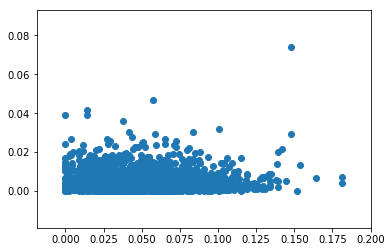

In [115]:
error_rbf_svr_year=abs(Y_test-rbf_svr_year_preds)
plt.scatter(x=Y_test,y=error_rbf_svr_year);

In [116]:
MAE_rbf_svr_year=MAE(y_true=Y_test,y_pred=rbf_svr_year_preds)
print("El MAE del modelo rbf_svr_year es:",MAE_rbf_svr_year)

El MAE del modelo rbf_svr_year es: 0.0047192586128071935


In [117]:
((MAE_rbf_svr_year/MAE_linear_svr_year)-1)*100

-0.7742702566700954

<font color='brown'>En el gráfico podemos ver el error absoluto de las predicciones del modelo rbf_svr_year con respecto al valor real (Y_test). El MAE del modelo rbf_svr_year es 0.0047192586128071935, un 0.77% menor que el del modelo linear_svr_year, que era el mejor de los modelos hasta ahora, por lo que **el modelo rbf_svr_year con las features de tasa de paro anual, predice mejor que el resto de modelos, aunque sólo levemente con respecto el modelo linear_svr_year que también utiliza las features de tasa de paro anual**.
    
Vamos a comprobar si existe algún municipio cuyo valor sea la media o un valor cercano:  
Vamos a comprobar el nivel de acierto o casi acierto del modelo teniendo en cuenta el mismo margen de error que en los modelos anteriores:</font>

In [118]:
aciertos_rbf_svr_year=error_rbf_svr_year==0
print("El modelo linear_svr_year ha acertado la tasa de paro en:",
      error_rbf_svr_year[aciertos_rbf_svr_year].shape[0],"municipios")

El modelo linear_svr_year ha acertado la tasa de paro en: 0 municipios


In [119]:
casi_aciertos_rbf_svr_year=error_rbf_svr_year<0.001
print("El modelo rbf_svr ha acertado la tasa de paro con un margen de error de 0.001 en:",
      error_rbf_svr_year[casi_aciertos_rbf_svr_year].shape[0],"municipios")

El modelo rbf_svr ha acertado la tasa de paro con un margen de error de 0.001 en: 454 municipios


<font color='brown'>Al igual que en el resto de modelos, no ha acertado ninguna tasa de paro, sin embargo, para el mismo margen de error usado en los anteriores modelos, el modelo rbf_svr_year, con las features de ratio anual, ha estado cerca de predecir correctamente la tasa de paro en 454 municipios, frente a los 451 del modelo linear_svr_year, que era el modelo con más aciertos hasta el momento.</font>

In [120]:
filename = './rbf_svr_year_preds.html'
_ = utils.generate_map(data=pd.concat([muns_population.loc[rbf_svr_year_preds.index], rbf_svr_year_preds], axis=1),
                       lat_col=utils.LAT_FIELD, long_col=utils.LON_FIELD,
                       unemploy_col=rbf_svr_year_preds.name if rbf_svr_year_preds.name is not None else 0,
                       cmap=color_range, coms=coms, provs=provs,
                       filename=filename)

In [121]:
IFrame(filename, width='100%', height='550px')

<font color='brown'>**Al igual que con el modelo anterior (linear_svr_year), son imperceptibles las diferencias con el mapa de los valores reales**.</font>

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Try to explain the behavior of the new non-linear model obtained.
</table>

<font color='brown'>NaN</font>

## 4. Summary

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Summarise the results obtained. There should be 5 models to compare:
<ol>
    <li> Dummy baseline.</li>
    <li> Municipality characteristics (linear and non-linear).</li>
    <li> Unemployment history 2006-2017 (linear and non-linear).</li>
</ol>
Which model would you choose if you had to go into production? Why?
 </td></tr>
</table>

In [122]:
features_summary=["Zero","Geográficas","Geográficas","Tasa anual","Tasa anual"]

modelos=["dummy","linear_svr","rbf_svr","linear_svr_year","rbf_svr_year"]

R2_train=[dummy.score(X_train_zeros, Y_train),
          best_acc_linear_svr,
          best_acc_rbf_svr,
          best_acc_linear_svr_year,
          best_acc_rbf_svr_year]

R2_score=[dummy.score(X_test_zeros, Y_test),
          best_model_score_linear_svr,
          best_model_score_rbf_svr,
          best_model_score_linear_svr_year,
          best_model_score_rbf_svr_year]

MAE_=[MAE_dummy,
      MAE_linear_svr,
      MAE_rbf_svr,
      MAE_linear_svr_year,
      MAE_rbf_svr_year]

Casi_Aciertos=[error_dummy[casi_aciertos_dummy].shape[0],
               error_linear_svr[casi_aciertos_linear_svr].shape[0],
               error_rbf_svr[casi_aciertos_rbf_svr].shape[0],
               error_linear_svr_year[casi_aciertos_linear_svr_year].shape[0],
               error_rbf_svr_year[casi_aciertos_rbf_svr_year].shape[0]]

Sumatorio_mean_fit_time=[0,
                         sum(gs_linear_svr.cv_results_["mean_fit_time"]),
                         sum(gs_rbf_svr.cv_results_["mean_fit_time"]),
                         sum(gs_linear_svr_year.cv_results_["mean_fit_time"]),
                         sum(gs_rbf_svr_year.cv_results_["mean_fit_time"])]

In [123]:
Summary=pd.DataFrame({"Features":features_summary,
                      "Modelo":modelos,
                      "R^2_train":R2_train,
                      "R^2_score":R2_score,
                      "MAE":MAE_,
                      "Casi Aciertos":Casi_Aciertos,
                      "Sumatorio_mean_fit_time":Sumatorio_mean_fit_time})

Summary.sort_values(by='R^2_score', ascending=False)

,Features,Modelo,R^2_train,R^2_score,MAE,Casi Aciertos,Sumatorio_mean_fit_time
4,Tasa anual,rbf_svr_year,0.935178,0.942418,0.004719,454,186.525666
3,Tasa anual,linear_svr_year,0.934120,0.941567,0.004756,451,50.823909
2,Geográficas,rbf_svr,0.568955,0.582518,0.013817,137,189.106016
1,Geográficas,linear_svr,0.345774,0.275306,0.017809,83,30.245530
0,Zero,dummy,0.000000,-0.000912,0.022956,79,0.000000


<font color='brown'>Como vemos en el dataframe "Summary", **las features que mejor han conseguido entrenar nuestros modelos han sido las tasas anuales de paro**, si nos atenemos sólo al tipo de modelo **el mejor modelo ha sido el no lineal (rbf)**.  
    De entre todos los modelos, **el que mejor scoring ha obtenido ha sido rbf_svr_year**, tanto en train, como en test, MAE y en el número de aciertos. Sin embargo, **a la hora de llevar a producción elegiría el modelo linear_svr_year**, que también entrena con las features de ratio de paro anuales, ya que es un modelo con unos **scoring casi idénticos al no lineal**, sin embargo es **mucho más simple**, **tarda menos en entrenar** y es un **modelo más fácil de entender** en caso de tener que llevarlo a cliente.</font>

## 5. Bonus round

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Explore further how we can generate even better predictions. The following are possible lines:
<ul>
    <li>Combining variables from municipalities and past unemployment rates (i.e., merging <i>X</i> and <i>X2</i>).</li>
<li>Using the original monthly data instead of yearly means.</li>
<li>Downloading and using additional data (economical, meteorological...) from other sources.</li>
</ul>
Feel free to edit this notebook from now on explaining your approach.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Imagine that instead of predicting the mean unemployment rate for 2018 you were asked to predict monthly unemployment rates for 2018. In other words, you would like to predict for January 2018, then for February 2018, and so on till December 2018.

Explain how you would tackle this problem with the data available. Extra points if you implement your proposal and show how it works in practice. Feel free to edit this notebook from now on explaining your approach.
 </td></tr>
</table>